# Web Scraping Tutorial for Tech Brown Bag 

## About web scraping

We use web scraping tools to gather human-readable data from HTML or XML when it is not available in a format that is more easily machine-readable (e.g., a database or flat file).

Before writing the script, it is helpful to understand the page structure and to identify the  elements to be captured.

Most web scraping tasks require content from multiple pages.  This set of pages could be known in advance, or it could be the result of traversing links discovered during the task.

After capturing the desired elements, we typically want to collect them into a single dataset for analysis.

More advanced web scraping tasks that simulate user behavior require the execution of client-side javascript by a browser, which is beyond the scope of this tutorial.

## About this demo

We will be scraping the [Barron's Top 1200 Financial Advisors](http://www.barrons.com/report/top-financial-advisors/1000/2018).  Please support content creators by visiting Barron's and its advertisers or subscribing.

Because advisors are listed separately by state, our tasks include:
- Examine the structure of the main page
- Capture the list of state pages from the main page
- Examine the structure of the state page and of its advisor table
- Traverse the list of state pages, capturing the advisor table from each.

## About the tools used

Most of our tasks can be done with three popular Python modules:
- [`requests`](http://docs.python-requests.org/en/master/): "HTTP for Humans" is an easy-to-use library for making HTTP requests.
- [`beautifulsoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a powerful library for HTML and XML parsing and data extraction.
- [`pandas`](https://pandas.pydata.org/) is widely used for dataset manipulation and analysis.  We will use its methods for creating, combining, and exporting the `DataFrame` object.

We will also make slight use of [`numpy`](https://docs.scipy.org/doc/numpy-1.14.0/reference/) for `array` operations, [`unicodedata`](https://docs.python.org/3.6/library/unicodedata.html) for character set standardization, and [`re`](https://docs.python.org/3/library/re.html) for non-HTML string operations.  It is [generally considered unwise](https://stackoverflow.com/a/1732454/2573061) to use `re` extensively for HTML parsing.

The above packages are all included in the [anaconda](https://conda.io/docs/user-guide/install/download.html) distribution.

## Getting started

We include the above modules in our script with `import` statements.

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from unicodedata import normalize
import re

Next we declare the location of the main page of our input and the file destination of our output.  We split the location of the main page into the domain and the page directory, because we will need to navigate through other pages in this domain.

In [29]:
HOME_DOMAIN = 'http://www.barrons.com'
HOME_DIR = '/report/top-financial-advisors/1000/2018'
OUT_CSV = '/Users/jandrews/workspace/barrons_financial_advisors.csv' # <---- your directory here

We declare [a user agent](https://en.wikipedia.org/wiki/User_agent#Use_in_HTTP) that will be passed with each request.  For now, we can use the user agent of the browser we will use to examine the pages.  For a larger-scale scraping project, we should declare a bot user agent with contact info.

In [30]:
HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) '
           'AppleWebKit/537.36 (KHTML, like Gecko) '
           'Chrome/50.0.2661.102 Safari/537.36'}

## Requesting and parsing a page

Since we will need to parse every page we will request, we can combine these actions in a single convenience function.  We will use an XML parser, `lxml` (in case there are non-HTML elements).  

In [31]:
def getSoup(url, headers):
    resp = requests.get(url, headers=headers)
    if resp.status_code==200:
         soup = BeautifulSoup(resp.text, 'lxml')
    else: 
        soup = None
        print('Unable to return content from: {}\n'.format(url))
    return soup

## Examine the structure of the main page

Let's take a look at the main page.  We see a drop-down menu with entries for each state plus the District of Columbia (which we'll call "regions").

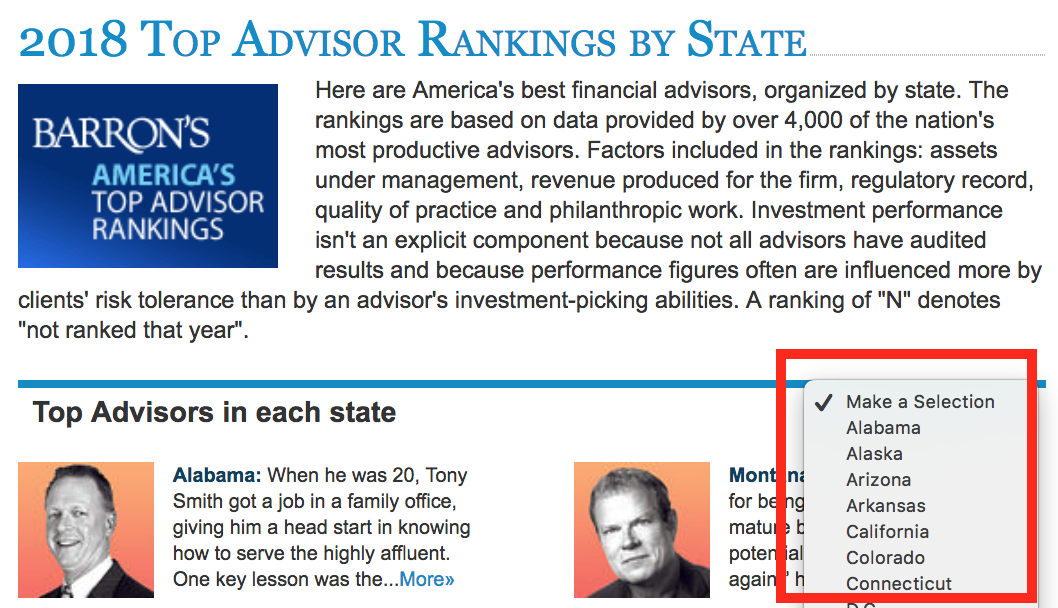

Now let's find the HTML code for this drop-down menu.  

You can do this in your browser, typically by right-clicking on the element and selecting "View Source" or "Inspect."

We see that the region table looks like this:  

## Get a list of region pages

Notice that each region page is given by `value=foo` inside an `option`, so we can capture the values of `foo` to get a list of region pages.  We need to exclude the `value="#"`and any `option` tags that do not contain a `value=` (or we might get a `KeyError` when we attempt to extract the `value`).  We can apply these exclusions with a [list comprehension](https://docs.python.org/3.6/tutorial/datastructures.html#list-comprehensions):

In [32]:
def getRegionDirs(homeDomain, homeDir, headers):
    soup = getSoup(homeDomain + homeDir, headers)
    opts = soup.find('select',{'id':'stateSelect'})
    return [x['value'] for x in opts.find_all('option') 
            if x and x['value'] != '#']  

## Examine the structure of a region page and table

Now let's follow one of those links to a region page.  Note that we'll need to concatenate the home domain from the main page and the page location from the drop-down menu, for example:

http://www.barrons.com/report/top-financial-advisors/1000/alabama/2018

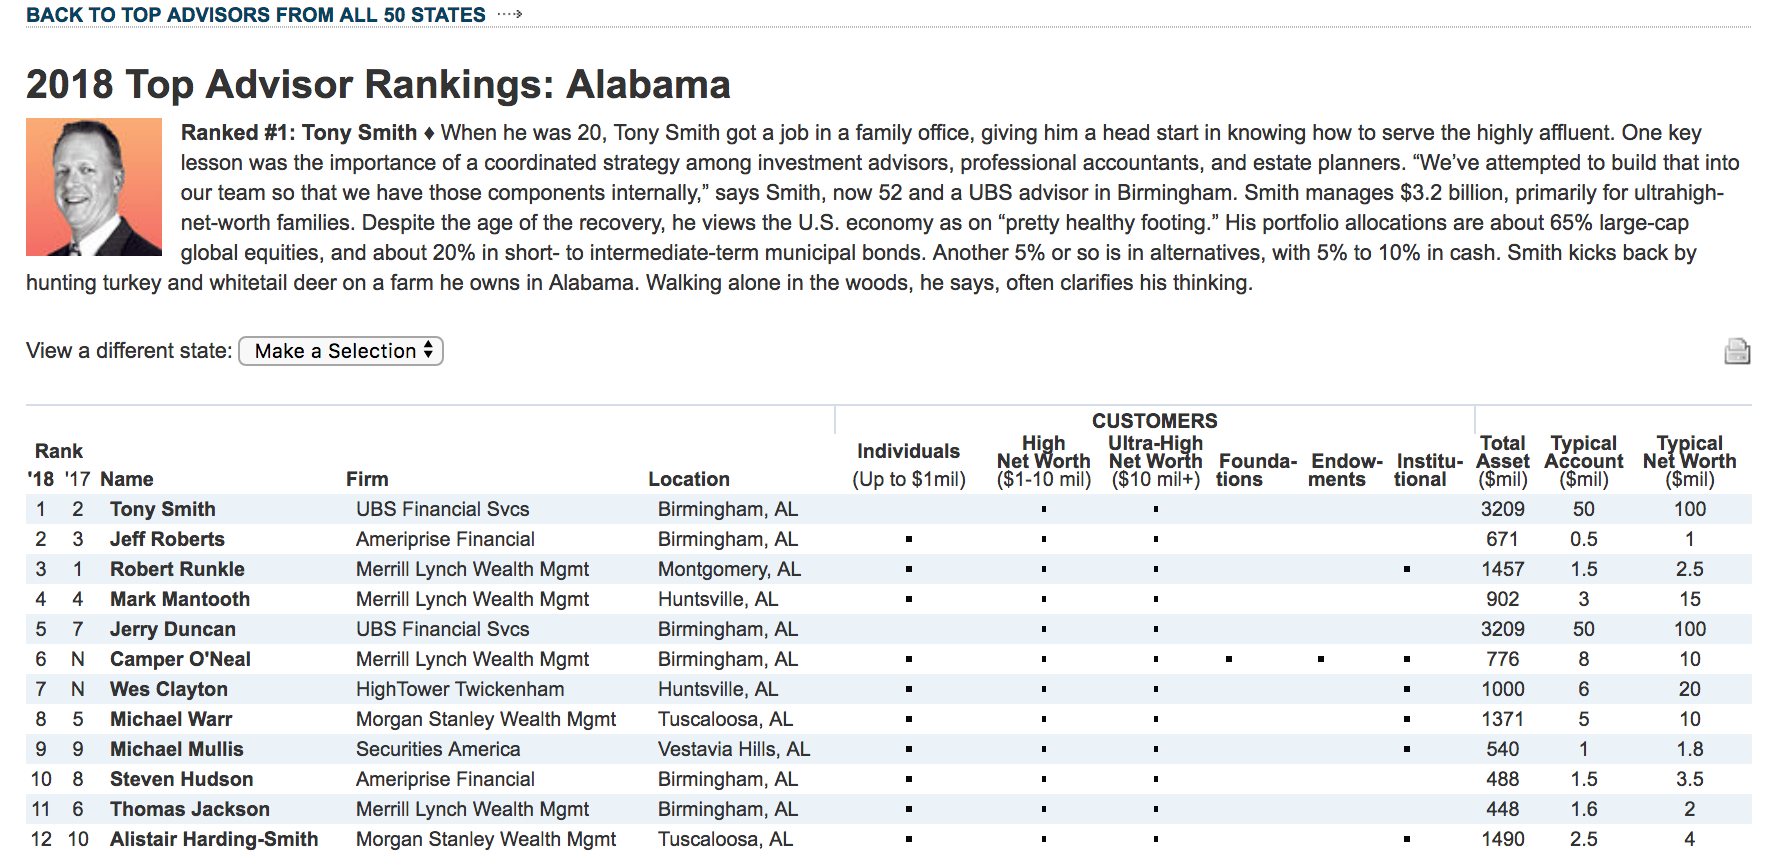

Inspecting the page content, we see that the table looks like:

Inspecting the table source, we note that:
- The table headers are formatted poorly, with some headers spanning multiple columns and rows.  We will have to parse the table headers carefully.
- Instead of a Yes/No entry for the six "Customers" columns (Ultra High Net Worth, etc.), "No" is shown by a blank `<td>` entry, and "Yes" is shown by an `img` in this entry.

## Getting and parsing the `table` object

### Getting the `table` object

Getting the table is simple, assuming there is only one `<table>` on the page.  The function `getRegionTable()` takes the HTTP inputs and returns the `table` element:

In [33]:
def getRegionTable(homeDomain, regionDir, headers):
    soup = getSoup(homeDomain + regionDir, headers)
    return soup.find('table')

### Parsing the `table` header rows

The tricky part is in parsing the headers, which are split across two elements of `<tr class="tableHeader">`.  

In the first header line, which uses `colspan=`, we will use `numpy.repeat().tolist()` to repeat the elements that span multiple columns.  

Now that the first and second header lines have an equal number of elements, we will do an element-wise concatenation across lines using list comprehension, [list unpacking](https://docs.python.org/3/tutorial/controlflow.html#tut-unpacking-arguments), [zip](https://docs.python.org/3/library/functions.html#zip), and [string formatting](https://pyformat.info/#simple) (phew!).  

The function `getTableHeaders()` takes a `table` element, does all this and returns a list of strings, one per column name. 

In [34]:
def getTableHeaders(table):
    headerTags = [t.find_all('th') for t in 
                           table.find_all('tr',{'class':'tableHeader'})]
    colspans = [ [int(item['colspan']) if item.has_attr('colspan') else int(1) for item in sublist]
                  for sublist in headerTags]
    # replace non-breaking spaces
    headers = [ [normalize('NFKD',item.get_text()).strip() for item in sublist] for sublist in headerTags]
    headerRows = [np.repeat(i,j).tolist() for i,j in zip(headers,colspans)]
    return ["{} {}".format(a,b).strip().replace('- ','') for a,b in zip(*headerRows)]


### Parsing the `table` data rows

Looking at the above structure, we see that the table data is contained in the `<tbody>` element, with entries in `<td>` elements.

If the `<td>` element contains a string, use that string (converted to UTF-8) for the data.  Otherwise, if it contains an `img` (i.e, the `bullet.gif`), represent the data as `"Y"`.  Otherwise, use an empty string.  Use a list comprehension to obtain a list (for each `<tr>`, or row) of lists (for each `<td>`, or column). Return this data as a `pandas.DataFrame` using the `from_records()` constructor on this nested list:

In [35]:
def getTableData(table, colNames = None):
    bodyTags = [t.find_all('td') for t in table.find('tbody').find_all('tr')]
    
    records = [ [normalize('NFKD',item.string).strip() if item.string
                   else 'Y' if item.find('img')
                   else ''
                   for item in sublist] for sublist in bodyTags]   
    return pd.DataFrame.from_records(records, columns=colNames)

Note that this `DataFrame` has no variable names yet -- those are in the headers parsed in the previous function.

### Putting the table together

Let's wrap the above three functions (`getRegionTable`, `getTableHeaders`, and `getTableData`) with a single function that takes the HTTP inputs and returns a `DataFrame` with variable names.  

We will also add a column named "region" which tells us which page the record came from. We could have captured that from the main page, but it's convenient to capture it here, with a regular expression that exploits the directory structure: `"/1000/StateName/2018"`

In [36]:
def getRegionData(homeDomain, regionDir, headers):
    table = getRegionTable(homeDomain, regionDir, headers)
    data = getTableData(table, colNames = getTableHeaders(table))
    data['region'] = re.findall('/1000/(\w+)/2018',regionDir)[0]
    return data

## The `main` function: putting it all together

All the heavy lifting is done.  Our `main` program needs to simply:
- Get the list of region pages
- Return a list of region tables (as `DataFrame`s)
- Concatenate the list of region tables into a single `DataFrame`
- Write the `DataFrame` to a file

Note that we can use `pandas.concat([df1, df2, ...])` to return a single `DataFrame`.  Thus, we can express our `main` loop as a list comprehension.

In [37]:
if __name__ == "__main__":
    data = pd.concat([getRegionData(HOME_DOMAIN, path, HEADERS) 
                       for path in getRegionDirs(HOME_DOMAIN, HOME_DIR, HEADERS)])
    out = open(OUT_CSV,'w',encoding='utf8')
    print('Writing {} results to: {}'.format( len(data.index), OUT_CSV))
    data.to_csv(out, index=False)
    out.close()

Writing 1200 results to: /Users/jandrews/workspace/barrons_financial_advisors.csv


Our output file looks like:

... and so on...

## Next Steps

Now that you've got a `DataFrame`, you can do all kinds of analysis. You can look at performance by firm, by city or state, by customer type, you name it.